In [3]:
import torch
import torch.nn as nn
from torch.optim import SGD
import math
import numpy as np

from matplotlib import pyplot as plt

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# DataSet
* Predict next value from noised sin curve.
* input is noised sin curve (50 values).
* gt is next value (1 value).

In [66]:
import math
import numpy as np

def mkDataSet(data_size, data_length=50, freq=60., noise=0.02):
    x = []
    gt = []

    for offset in range(data_size):
        x.append([[math.sin(2 * math.pi * (offset + i) / freq) + np.random.normal(loc=0.0, scale=noise)] for i in range(data_length)])
        gt.append([math.sin(2 * math.pi * (offset + data_length) / freq)])

    return x, gt

In [136]:
x, gt = mkDataSet(50)

In [143]:
print('len(x): ', len(x), 'len(gt): ', len(gt))
print('len(x[0]): ', len(x[0]), 'len(gt[0]): ', len(gt[0]))

len(x):  50 len(gt):  50
len(x[0]):  50 len(gt[0]):  1


# Display DataSet
* Predict next value from noised sin curve.
* input is noised sin curve (50 values).
* gt is next value (1 value).

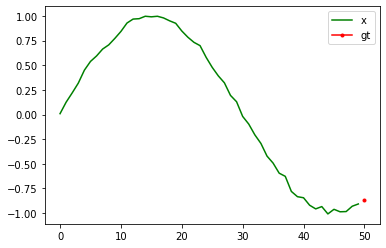

In [144]:
fig, ax = plt.subplots()

# 1st batch.
data_length =50
_y = x[0]
_x = [i for i in range(data_length)]

gt0 = gt[0]
ax.plot(_x, _y, color='green', label='x')
ax.plot(_x[-1]+1, gt0, color='red', label='gt', marker='.')
ax.legend(loc=0) 

plt.show()

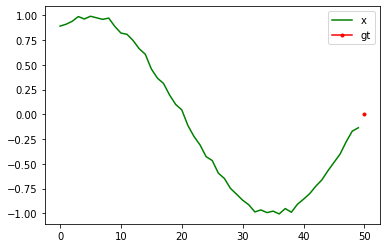

In [145]:
fig, ax = plt.subplots()

# 10th batch.
data_length =50
_y = x[10]
_x = [i for i in range(data_length)]

gt0 = gt[10]
ax.plot(_x, _y, color='green', label='x')
ax.plot(_x[-1]+1, gt0, color='red', label='gt', marker='.')
ax.legend(loc=0)

plt.show()

# LSTM Model
* batch_first = True makes input format as [batch_size, time_sequence, emb_vec]

In [80]:
import torch
import torch.nn as nn

class Predictor(nn.Module):
    def __init__(self, inputDim, hiddenDim, outputDim):
        super(Predictor, self).__init__()

        self.rnn = nn.LSTM(input_size = inputDim, hidden_size = hiddenDim, batch_first = True)
        self.output_layer = nn.Linear(hiddenDim, outputDim)
    
    def forward(self, inputs, hidden0=None):
        output, (hidden, cell) = self.rnn(inputs, hidden0)
        # use only final time_sequence
        output = self.output_layer(output[:, -1, :])

        return output

# Training and Validation

In [103]:
def mkRandomBatch(train_x, train_t, batch_size=10):
    batch_x = []
    batch_t = []

    for _ in range(batch_size):
        idx = np.random.randint(0, len(train_x) - 1)
        batch_x.append(train_x[idx])
        batch_t.append(train_t[idx])
    
    return torch.tensor(batch_x, device=device), torch.tensor(batch_t, device=device)

def main():
    training_size = 10000
    test_size = 1000
    epochs_num = 100
    hidden_size = 5
    batch_size = 100

    train_x, train_t = mkDataSet(training_size)
    test_x, test_t = mkDataSet(test_size)

    model = Predictor(1, hidden_size, 1).to(device)
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=0.01)

    for epoch in range(epochs_num):
        # training
        running_loss = 0.0
        training_accuracy = 0.0
        for i in range(int(training_size / batch_size)):
            optimizer.zero_grad()

            data, label = mkRandomBatch(train_x, train_t, batch_size)
            output = model(data)

            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            training_accuracy += np.sum(np.abs((output.data - label.data).to('cpu').numpy()) < 0.1)

        #test
        test_accuracy = 0.0
        for i in range(int(test_size / batch_size)):
            offset = i * batch_size
            data, label = torch.tensor(test_x[offset:offset+batch_size], device=device), torch.tensor(test_t[offset:offset+batch_size], device=device)
            
            output = model(data, None)
            
            test_accuracy += np.sum(np.abs((output.data - label.data).to('cpu').numpy()) < 0.1)
        
        training_accuracy /= training_size
        test_accuracy /= test_size

        print('%d loss: %.3f, training_accuracy: %.5f, test_accuracy: %.5f' % (
            epoch + 1, running_loss, training_accuracy, test_accuracy))

In [104]:
main()

1 loss: 40.253, training_accuracy: 0.06920, test_accuracy: 0.08500
2 loss: 26.288, training_accuracy: 0.08450, test_accuracy: 0.10200
3 loss: 14.803, training_accuracy: 0.10860, test_accuracy: 0.11900
4 loss: 8.114, training_accuracy: 0.11230, test_accuracy: 0.12900
5 loss: 5.648, training_accuracy: 0.11980, test_accuracy: 0.13100
6 loss: 4.696, training_accuracy: 0.12420, test_accuracy: 0.13600
7 loss: 4.245, training_accuracy: 0.14110, test_accuracy: 0.14700
8 loss: 3.833, training_accuracy: 0.15400, test_accuracy: 0.15300
9 loss: 3.538, training_accuracy: 0.15130, test_accuracy: 0.15500
10 loss: 3.361, training_accuracy: 0.15400, test_accuracy: 0.16400
11 loss: 3.149, training_accuracy: 0.16780, test_accuracy: 0.18100
12 loss: 2.966, training_accuracy: 0.17670, test_accuracy: 0.18400
13 loss: 2.823, training_accuracy: 0.17300, test_accuracy: 0.18200
14 loss: 2.680, training_accuracy: 0.18860, test_accuracy: 0.19300
15 loss: 2.543, training_accuracy: 0.19420, test_accuracy: 0.20600
1